# Data Science, Classification Analysis

### Data Cleaning, Feature Engineering, Imputation and Classification

This Notebook runs over Jupyter docker instance. It can be found in the link:
    https://github.com/jupyter/docker-stacks/tree/master/tensorflow-notebook

### Number of CPUs available for Docker Container

In [2]:
!cat /proc/cpuinfo | awk '/^processor/{print $3}' | tail -1

1


### Import Standard python libraries

In [3]:
import io, os, sys, types, time, datetime, math, random, requests, subprocess, tempfile
from io import StringIO

### Import Packages

In [4]:
# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# Feature Selection and Encoding
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning 
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf

# Grid and Random Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc

# Managing Warnings 
import warnings
warnings.filterwarnings('ignore')

# Plot the Figures Inline
%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Our Goal

In this Notebook, we will be using the Contraceptive Prevalence dataset.
This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.
   
The dataset can be found here : https://archive.ics.uci.edu/ml/datasets/cmc

## Download the Data and Load it

Let's download the data and save it to a folder in our local directory called 'dataset'. Download it once, and then comment the code out for subsequent runs.

After downloading the data, we load it directly from Disk into a Pandas Dataframe in Memory. Depending on the memory available to the Docker instance, this may be a problem.

The data is not already separated into the Training and Test datasets. We will use the data for data exploration, and then separate them before running our algorithms.

In [5]:
# Download
DATASET = (
"https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data",
"https://archive.ics.uci.edu/ml/machine-learning-databases/university/cmc.names"
)

def download_data(path='dataset', urls=DATASET):
    if not os.path.exists(path):
        os.mkdir(path)
        
    for url in urls:
        response = requests.get(url)
        name = os.path.basename(url)
        with open(os.path.join(path, name), 'wb') as f:
            f.write(response.content)

download_data()

Number of Instances: 1473

Number of Attributes: 10 (including the class attribute)

Attribute Information:

   1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use 
                                                        2=Long-term
                                                        3=Short-term

Missing Attribute Values: None

In [6]:
# Load the dataset

headers = ['WifeAge', 'WifeEducation',
          'HusbandEducation', 'ChildrenBorn',
          'WifeReligion', 'WifeWorking',
          'HusbandOccupation','SOLIndex',
          'MediaExposure','ContraceptiveMethodUsed']

raw_data = pd.read_csv("dataset/cmc.data",
                      header = None,
                      names = headers,
                      sep = ',',
                      engine='python')
raw_data.head()

,WifeAge,WifeEducation,HusbandEducation,ChildrenBorn,WifeReligion,WifeWorking,HusbandOccupation,SOLIndex,MediaExposure,ContraceptiveMethodUsed
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [7]:
# Displaying the size of the dataframe in Memory
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("Bytes", "KB", "MB", "GB", "TB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

convert_size(raw_data.memory_usage().sum())

'115.16 KB'

## Data Explorations

Let's start with some simple Univariate (one feature) analysis.

Features can be of multiple types:
- **Nominal:**  is for mutual exclusive, but not ordered, categories.
- **Ordinal:** is one where the order matters but not the difference between values.
- **Interval:** is a measurement where the difference between two values is meaningful.
- **Ratio:** has all the properties of an interval variable, and also has a clear definition of 0.0.

There are multiple ways of manipulating each feature type, but for simplicity, we'll define only two feature types:
- **Numerical:** any feature that contains numeric values.
- **Categorical:** any feature that contains categories, or text.

In [8]:
#Since raw_data is encoded with categorical variables already
#we will decode the variables to their labels and check the dataframe

#make a copy
dataset_raw = raw_data.copy()

In [9]:
#define dictionary for labels and replace it in the dataframe

lowtohigh = { 1: "most_low", 2: "low", 3:"high", 4:"most_high"}
dataset_raw.WifeEducation.replace(lowtohigh, inplace=True)
dataset_raw.HusbandEducation.replace(lowtohigh, inplace=True)
dataset_raw.SOLIndex.replace(lowtohigh, inplace=True)
dataset_raw.HusbandOccupation.replace(lowtohigh, inplace=True)

wifereligion = {0:"Non_Islam", 1:"Islam"}
dataset_raw.WifeReligion.replace(wifereligion, inplace=True)

wifeworking = {0:"Yes", 1:"No"}
dataset_raw.WifeWorking.replace(wifeworking, inplace=True)

mediaexposure = {0: "Good", 1: "Not_Good"}
dataset_raw.MediaExposure.replace(mediaexposure, inplace=True)

contraceptive = {1: "No_Use", 2:"Long_Term", 3:"Short_Term"}
dataset_raw.ContraceptiveMethodUsed.replace(contraceptive, inplace=True)
dataset_raw.head()

,WifeAge,WifeEducation,HusbandEducation,ChildrenBorn,WifeReligion,WifeWorking,HusbandOccupation,SOLIndex,MediaExposure,ContraceptiveMethodUsed
0,24,low,high,3,Islam,No,low,high,Good,No_Use
1,45,most_low,high,10,Islam,No,high,most_high,Good,No_Use
2,43,low,high,7,Islam,No,high,most_high,Good,No_Use
3,42,high,low,9,Islam,No,high,high,Good,No_Use
4,36,high,high,8,Islam,No,high,low,Good,No_Use


In [10]:
#raw_data dataframe does not changes
raw_data.head()

,WifeAge,WifeEducation,HusbandEducation,ChildrenBorn,WifeReligion,WifeWorking,HusbandOccupation,SOLIndex,MediaExposure,ContraceptiveMethodUsed
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [11]:
# Describing all the Numerical Features
dataset_raw.describe()

,WifeAge,ChildrenBorn
count,1473.000000,1473.000000
mean,32.538357,3.261371
std,8.227245,2.358549
min,16.000000,0.000000
25%,26.000000,1.000000
50%,32.000000,3.000000
75%,39.000000,4.000000
max,49.000000,16.000000


In [12]:
# Describing all the Categorical Features
dataset_raw.describe(include=['O'])

,WifeEducation,HusbandEducation,WifeReligion,WifeWorking,HusbandOccupation,SOLIndex,MediaExposure,ContraceptiveMethodUsed
count,1473,1473,1473,1473,1473,1473,1473,1473
unique,4,4,2,2,4,4,2,3
top,most_high,most_high,Islam,No,high,most_high,Good,No_Use
freq,577,899,1253,1104,585,684,1364,629


In [13]:
dataset_raw.dtypes

WifeAge                     int64
WifeEducation              object
HusbandEducation           object
ChildrenBorn                int64
WifeReligion               object
WifeWorking                object
HusbandOccupation          object
SOLIndex                   object
MediaExposure              object
ContraceptiveMethodUsed    object
dtype: object

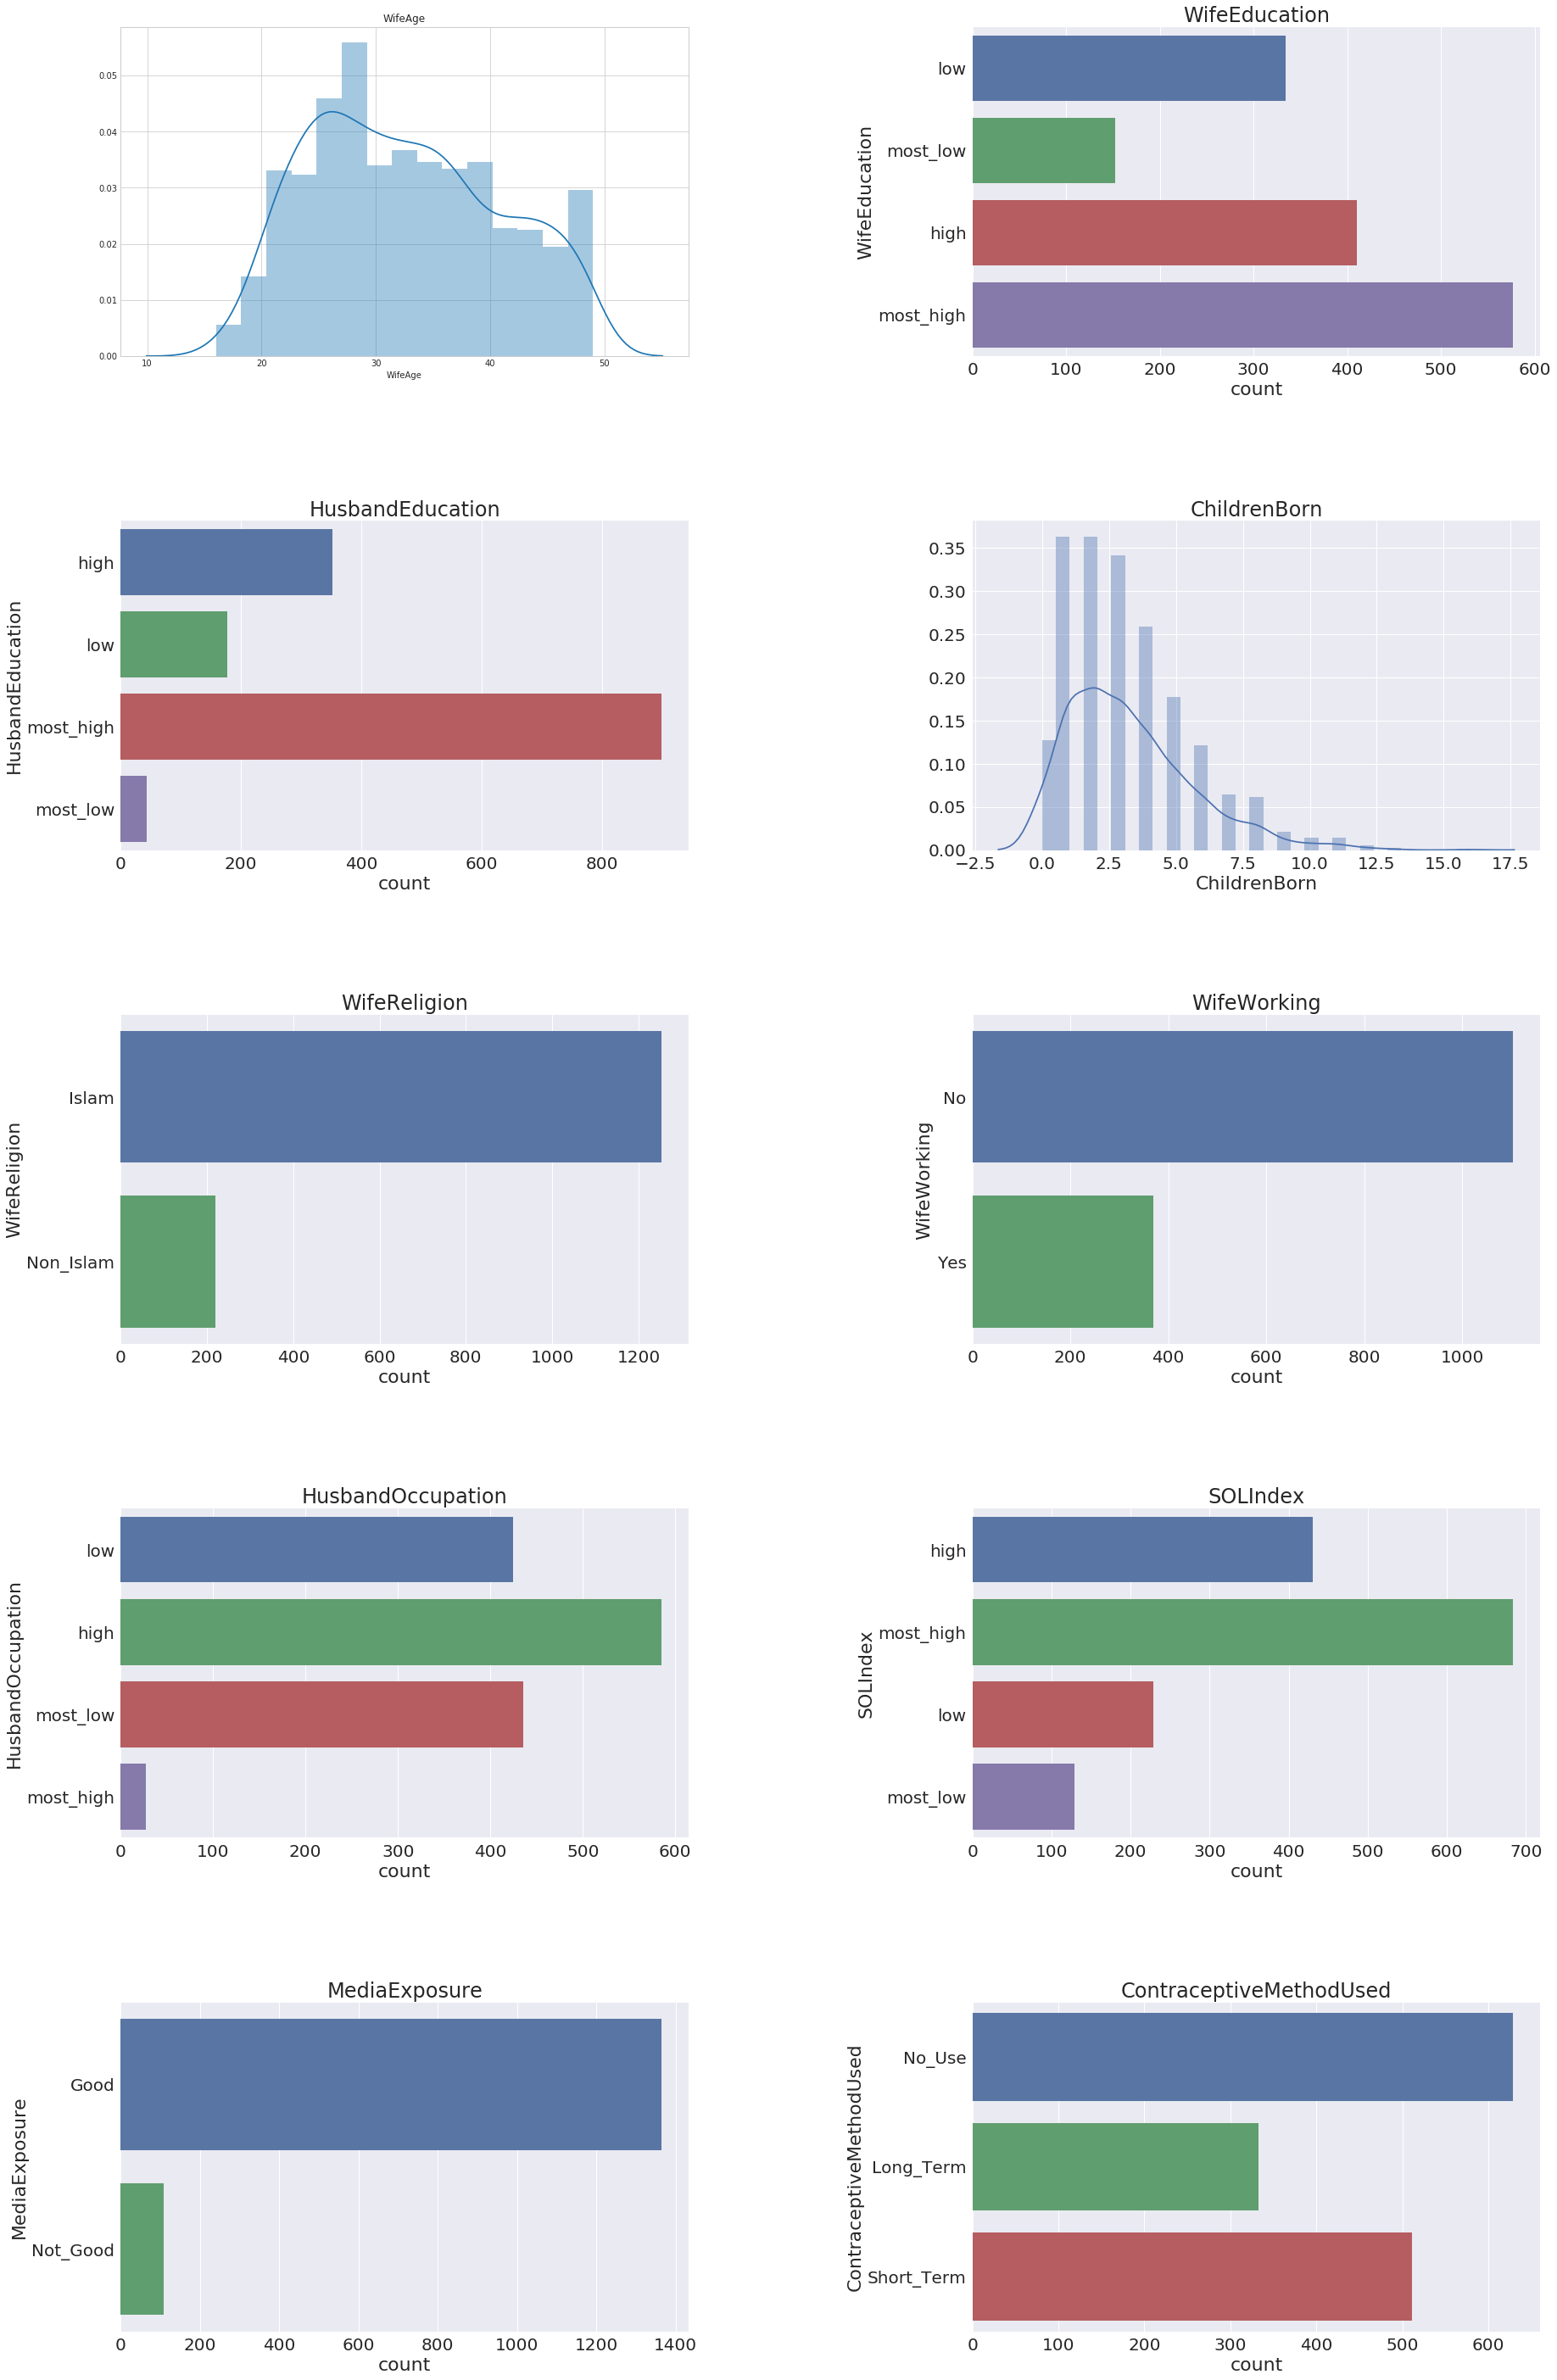

In [14]:
#Let's plot the distribution of each feature

def plot_distribution(dataset, cols=2, width=30, height=50, hspace=0.5, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1])/cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(column)
        sns.set(font_scale=2)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:20] for s in g.get_yticklabels()]
            g.set(yticklabels = substrings)
            #sns.set(font_scale=2)
            #plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            #plt.xticks(rotation=25)

            
plot_distribution(dataset_raw)

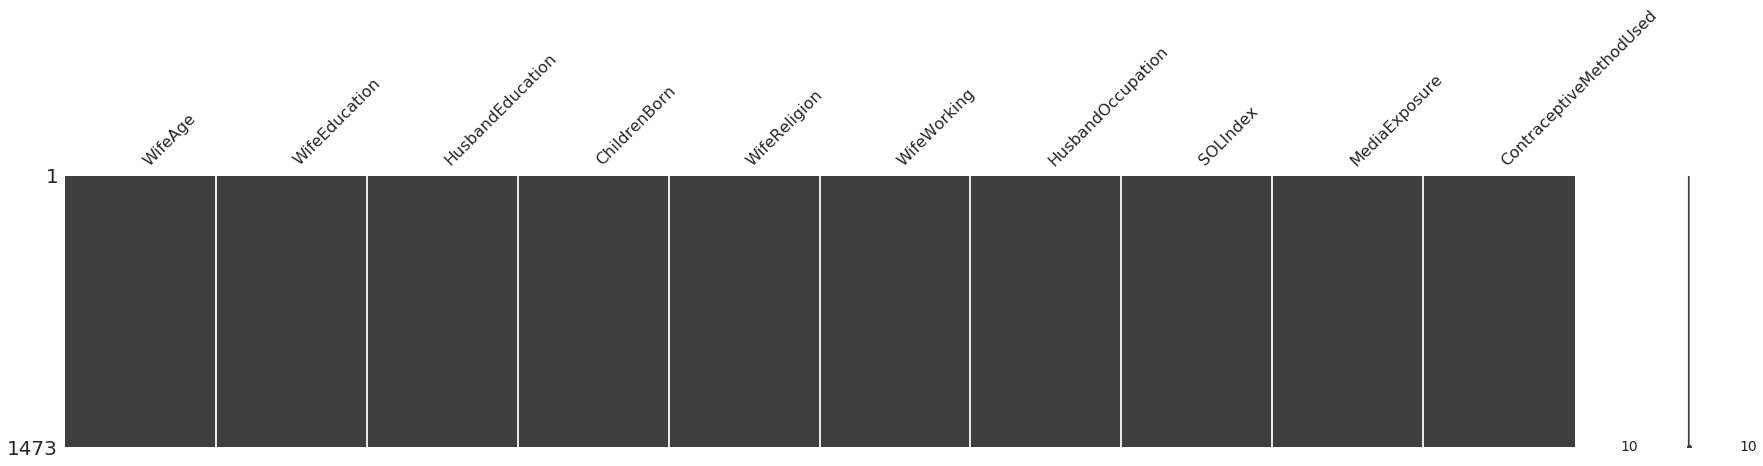

In [15]:
# How many missing values are there in our dataset?
missingno.matrix(dataset_raw, figsize = (30,5))

#There are no missing values in the dataset

## Feature Engineering

- **Discretization**: We can choose to either discretize some of the continuous variables we have, as some algorithms will perform faster. We are going to do both, and compare the results of the ML algorithms on both discretized and non discretised datasets. We'll call these datasets:

- dataset_bin => where Continuous variables are Discretised

- dataset_con => where Continuous variables are Continuous

- **Reframe Numerical Quantities**: Changing from grams to kg, and losing detail might be both wanted and efficient for calculation

- **Feature Crossing**: Creating new features as a combination of existing features. Could be multiplying numerical features, or combining categorical variables. This is a great way to add domain expertise knowledge to the dataset.

In [16]:
# To perform our data analysis, let's create new dataframes
dataset_bin = pd.DataFrame() #To contain our dataframe with our discretized continuous variable
dataset_con = pd.DataFrame() #To contain our dataframe with continuous variable


### Feature: ContraceptiveMethodUsed


In [17]:
dataset_bin['ContraceptiveMethodUsed'] = dataset_raw['ContraceptiveMethodUsed']
dataset_con['ContraceptiveMethodUsed'] = dataset_raw['ContraceptiveMethodUsed']


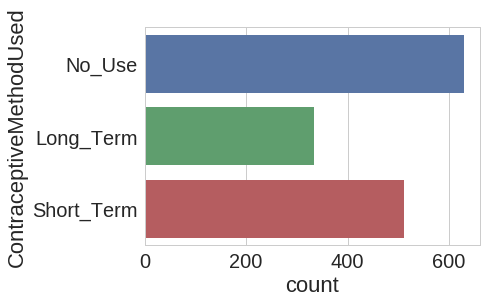

In [18]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
sns.countplot(y="ContraceptiveMethodUsed", data=dataset_bin)

### Feature: WifeAge

We will use the Pandas Cut function to bin the data in equally sized buckets.

In [19]:
dataset_bin['WifeAge'] = pd.cut(raw_data['WifeAge'],10) #discretised
dataset_con['WifeAge'] = raw_data['WifeAge'] #non-discretised

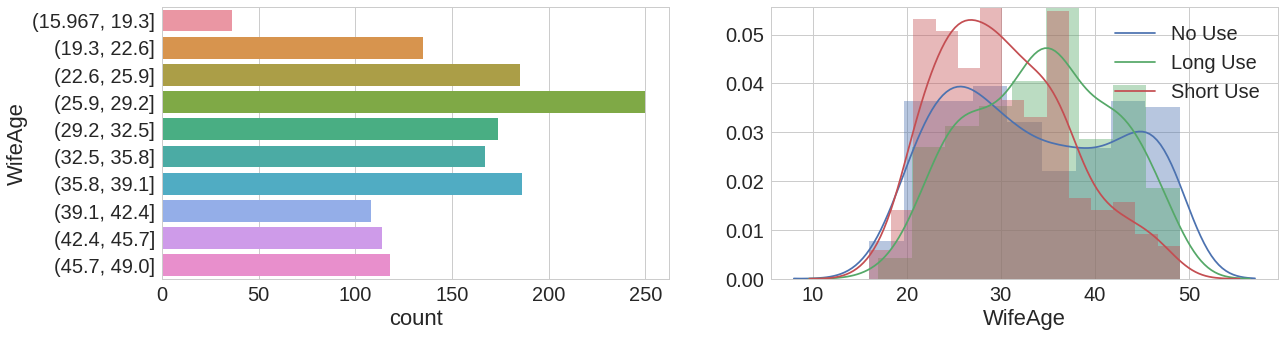

In [20]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(y="WifeAge", data=dataset_bin);
plt.subplot(1,2,2)

sns.distplot(dataset_con.loc[dataset_con['ContraceptiveMethodUsed']=="No_Use"]['WifeAge'], kde_kws={"label":"No Use"});
sns.distplot(dataset_con.loc[dataset_con['ContraceptiveMethodUsed']=="Long_Term"]['WifeAge'], kde_kws={"label":"Long Use"});
sns.distplot(dataset_con.loc[dataset_con['ContraceptiveMethodUsed']=="Short_Term"]['WifeAge'], kde_kws={"label":"Short Use"});

### Feature: WifeEducation

In [21]:
dataset_bin['WifeEducation'] = dataset_raw['WifeEducation']
dataset_con['WifeEducation'] = dataset_raw['WifeEducation']

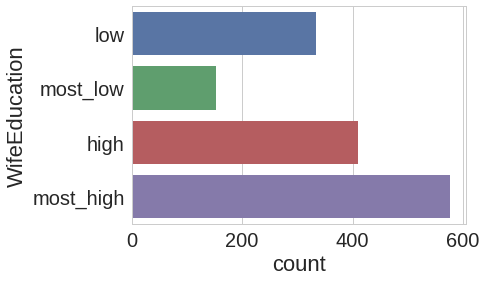

In [22]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
sns.countplot(y="WifeEducation", data=dataset_bin)

### Feature: HusbandEducation

In [23]:
dataset_bin['HusbandEducation'] = dataset_raw['HusbandEducation']
dataset_con['HusbandEducation'] = dataset_raw['HusbandEducation']

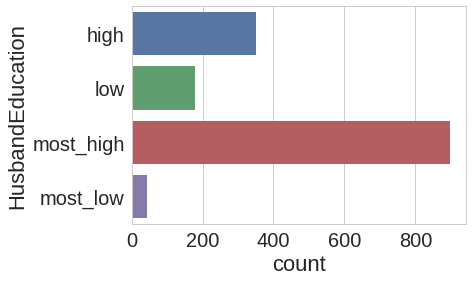

In [24]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
sns.countplot(y="HusbandEducation", data=dataset_bin)

### Feature: WifeReligion

In [25]:
dataset_bin['WifeReligion'] = dataset_raw['WifeReligion']
dataset_con['WifeReligion'] = dataset_raw['WifeReligion']

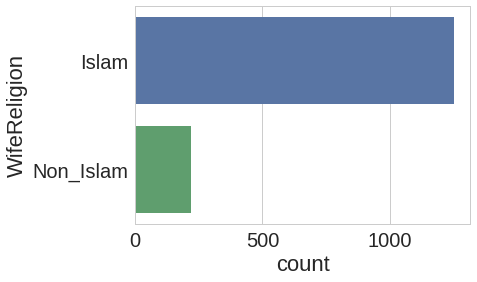

In [26]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
sns.countplot(y="WifeReligion", data=dataset_bin)

### Feature: WifeWorking

In [27]:
dataset_bin['WifeWorking'] = dataset_raw['WifeWorking']
dataset_con['WifeWorking'] = dataset_raw['WifeWorking']

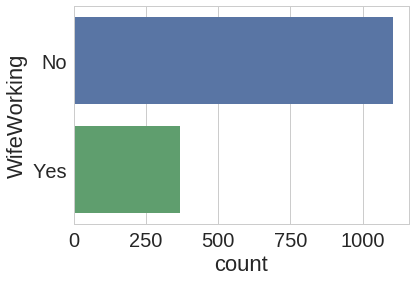

In [28]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
sns.countplot(y="WifeWorking", data=dataset_bin)

### Feature: HusbandEducation

In [29]:
dataset_bin['HusbandEducation'] = dataset_raw['HusbandEducation']
dataset_con['HusbandEducation'] = dataset_con['HusbandEducation']

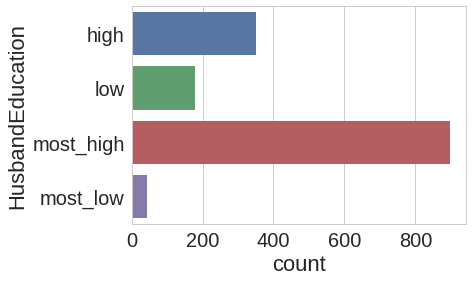

In [30]:
plt.style.use('seaborn-whitegrid')
fig=plt.figure()
sns.countplot(y="HusbandEducation", data = dataset_bin)

### Feature: SOLIndex

In [31]:
dataset_bin['SOLIndex'] = dataset_raw['SOLIndex']
dataset_con['SOLIndex'] = dataset_raw['SOLIndex']

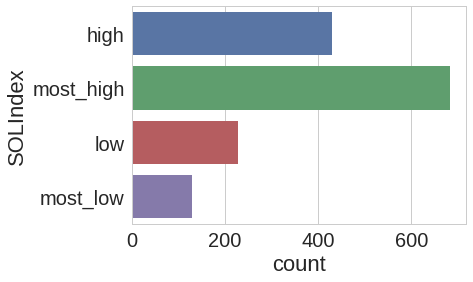

In [32]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure()
sns.countplot(y="SOLIndex", data=dataset_bin)

### Feature: MediaExposure

In [33]:
dataset_bin['MediaExposure'] = dataset_raw['MediaExposure']
dataset_con['MediaExposure'] = dataset_raw['MediaExposure']

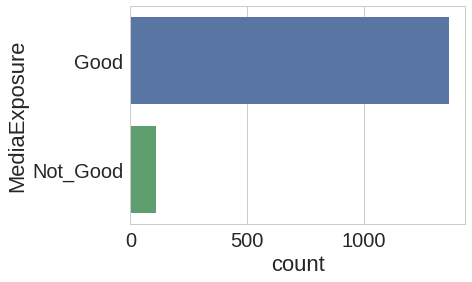

In [34]:
plt.style.use('seaborn-whitegrid')
fig=plt.figure()
sns.countplot(y='MediaExposure', data=dataset_bin)

### Feature: ChildrenBorn

In [35]:
dataset_bin['ChildrenBorn'] = pd.cut(dataset_raw['ChildrenBorn'], 16) #discretised
dataset_con['ChildrenBorn'] = dataset_raw['ChildrenBorn'] #non-discretised

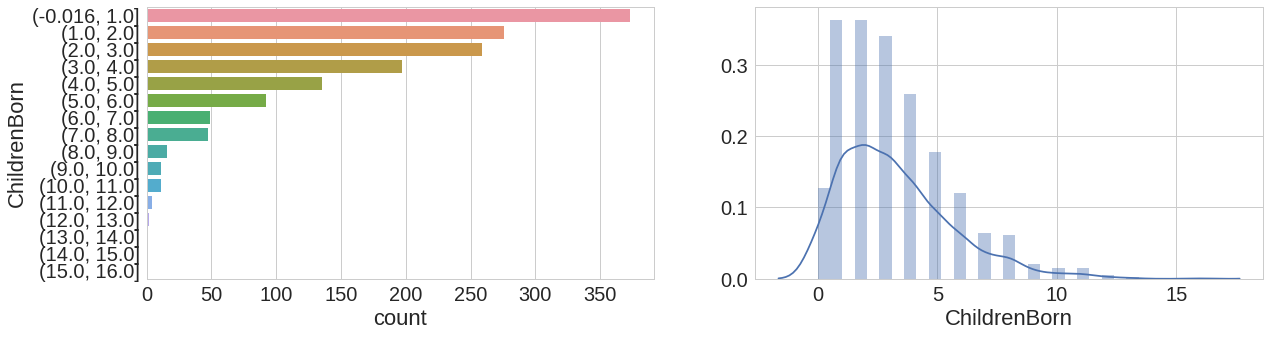

In [36]:
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
sns.countplot(y="ChildrenBorn", data=dataset_bin);
plt.subplot(1,2,2)
sns.distplot(dataset_con['ChildrenBorn']);

## Bivariate Analysis

So far, we have analyzed all features individually. Let's combine these features to understand the interactions between thhem

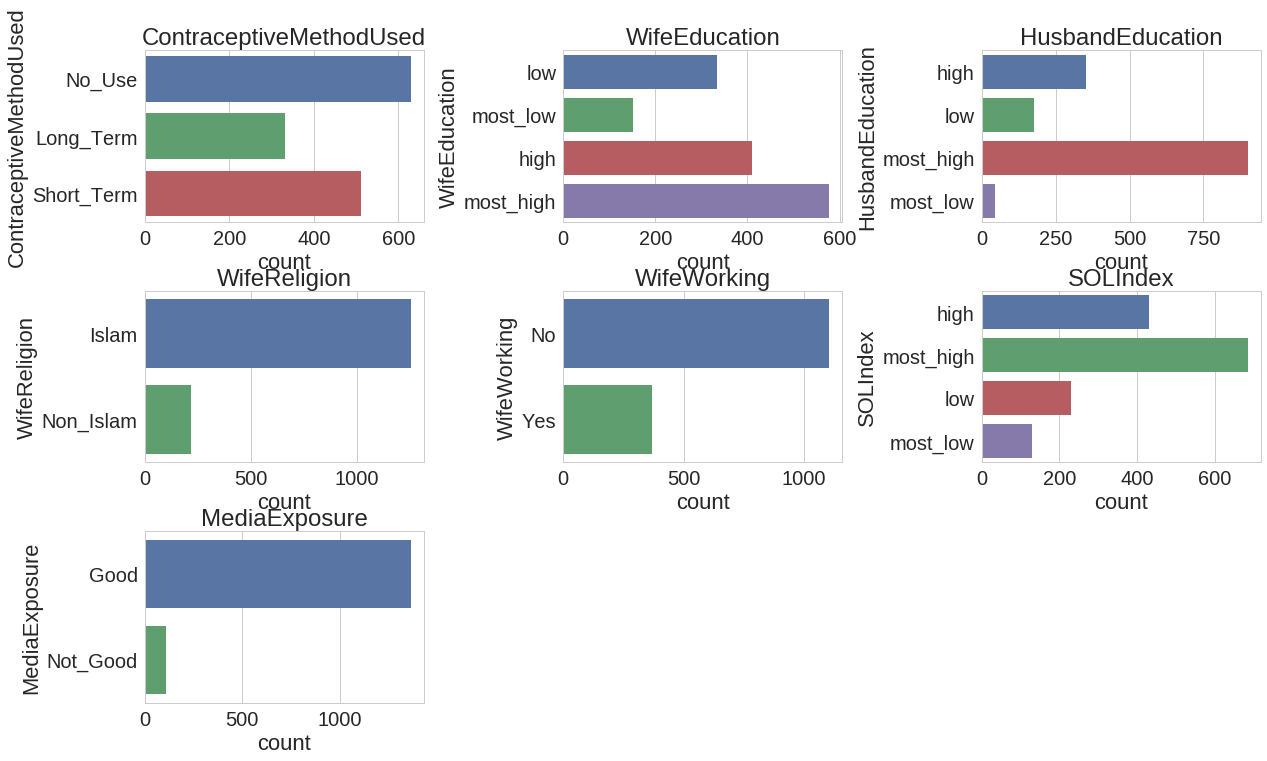

In [42]:
# Plot a count of thhe categories from each categorical feature split by our prediction class: contraceptivemethodused

def plot_bivariate_bar(dataset, hue, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    dataset = dataset.select_dtypes(include=[np.object])
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1])/ cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y = column, data=dataset)
            substrings = [s.get_text()[:10] for s in g.get_yticklabels()]
            g.set(yticklabels = substrings)
            
plot_bivariate_bar(dataset_con, hue='ContraceptiveMethodUsed', cols=3, width=20, height=12, hspace=0.4, wspace=0.5)

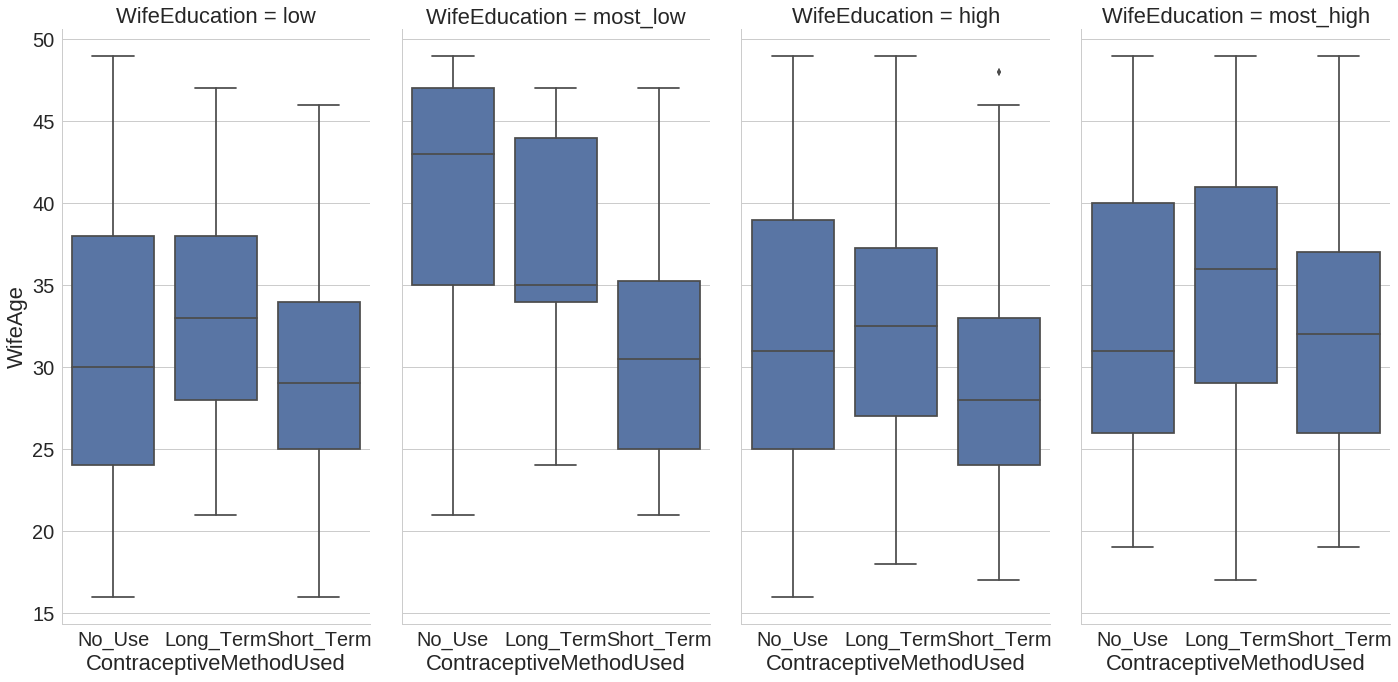

In [47]:
# Effect of WifeEducation and WifeAge on ContraceptiveMethodUsed, across WifeEducation.
plt.style.use('seaborn-whitegrid')
g = sns.FacetGrid(dataset_con, col='WifeEducation', size=10, aspect=0.5)
g = g.map(sns.boxplot, 'ContraceptiveMethodUsed', 'WifeAge')

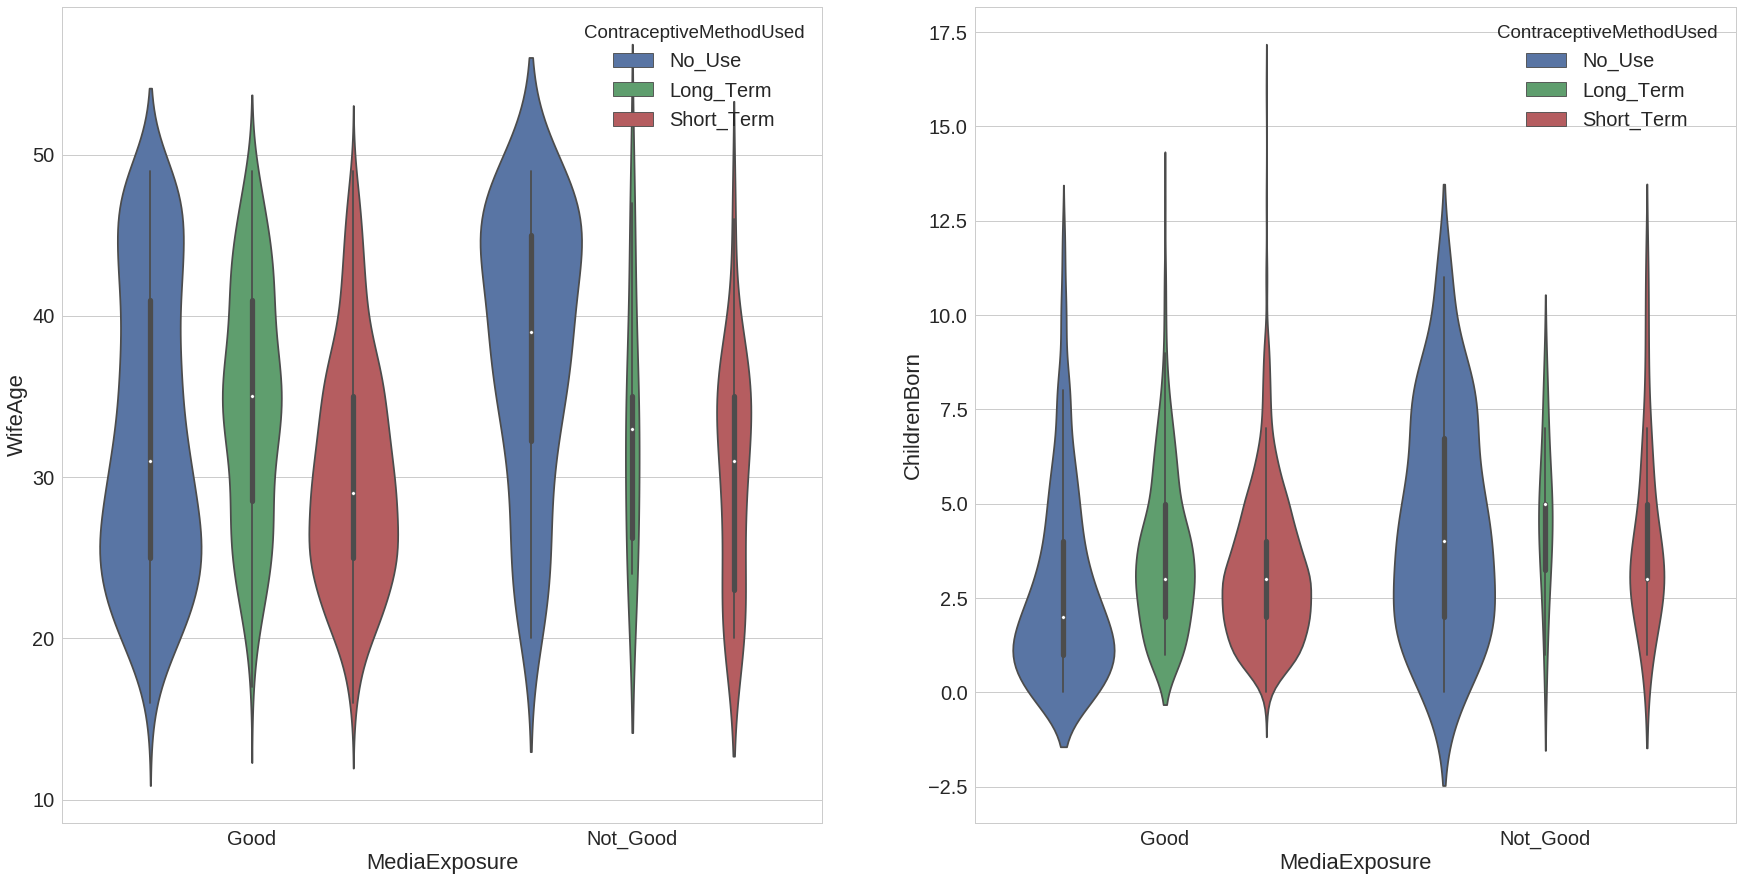

In [75]:
# Historical Trends on MediaExposure, WifeAge, ChildrenBorn impact on ContraceptiveMethodUsed.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
sns.violinplot(x = 'MediaExposure', y = 'WifeAge', hue='ContraceptiveMethodUsed', data=dataset_con, split=False, scale='count')

plt.subplot(1,2,2)
sns.violinplot(x = 'MediaExposure', y = 'ChildrenBorn', hue = 'ContraceptiveMethodUsed', data=dataset_con, split=False, scale='count')


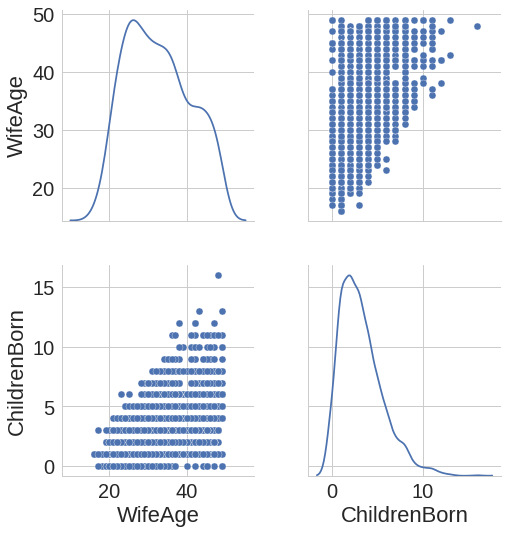

In [79]:
# Interaction between pairs of features.
sns.pairplot(dataset_con[['WifeAge', 'ChildrenBorn']],
            #hue = "ContraceptiveMethodUsed",
            diag_kind="kde",
            size=4)

## Feature Crossing: WifeAge, ChildrenBorn

We can create new variables, adding knowledge on the interaction between features

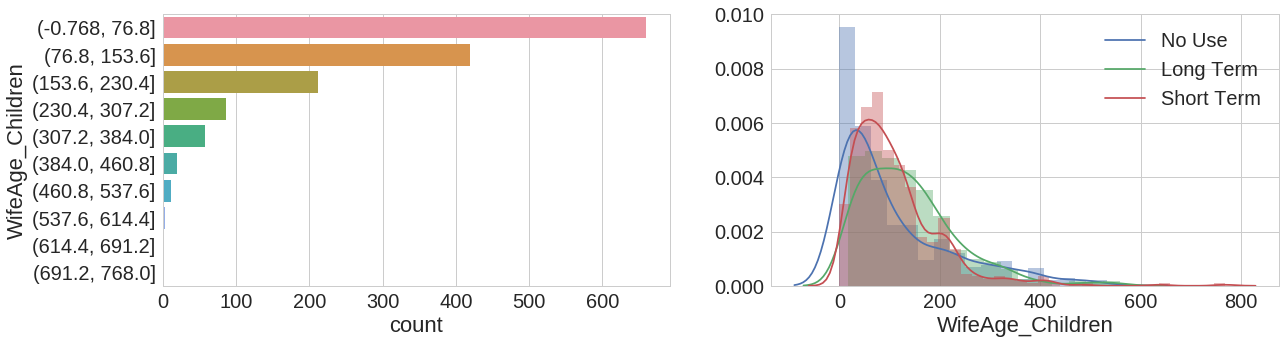

In [82]:
# Crossing Numerical Features
# Though there is no sense of doing it here, tihs has been shown for reference.
dataset_con['WifeAge_Children'] = dataset_con['WifeAge'] * dataset_con['ChildrenBorn']

dataset_bin['WifeAge_Children'] = pd.cut(dataset_con['WifeAge_Children'], 10)
dataset_con['WifeAge_Children'] = dataset_con['WifeAge_Children']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.countplot(y="WifeAge_Children", data=dataset_bin);
plt.subplot(1,2,2)
sns.distplot(dataset_con.loc[dataset_con['ContraceptiveMethodUsed']=='No_Use']['WifeAge_Children'], kde_kws={"label":"No Use"});
sns.distplot(dataset_con.loc[dataset_con['ContraceptiveMethodUsed']=='Long_Term']['WifeAge_Children'], kde_kws={"label":"Long Term"});
sns.distplot(dataset_con.loc[dataset_con['ContraceptiveMethodUsed']=='Short_Term']['WifeAge_Children'], kde_kws={"label":"Short Term"});


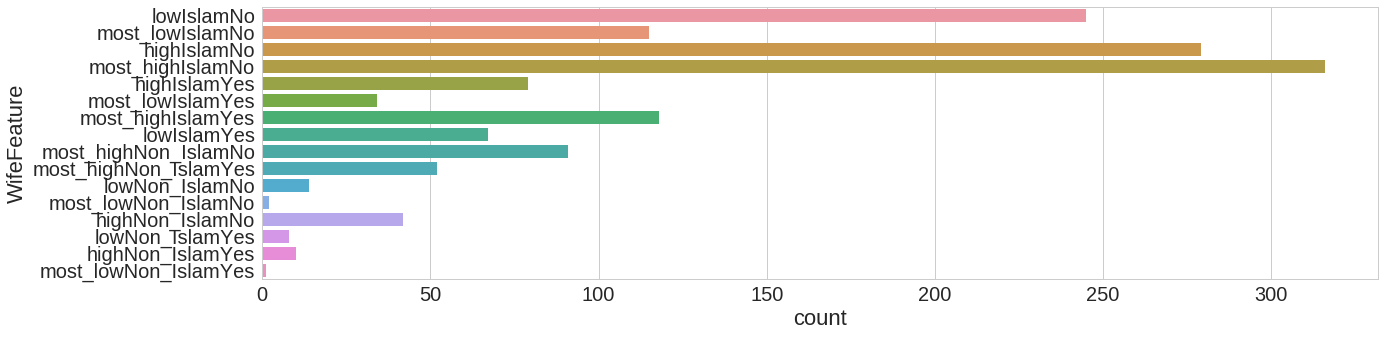

In [84]:
# Crossing Categorical Features
dataset_bin['WifeFeature'] = dataset_con['WifeFeature'] = dataset_con['WifeEducation']+dataset_con['WifeReligion']+dataset_con['WifeWorking']

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(20,5))
sns.countplot(y="WifeFeature", data=dataset_bin)

# Machine Learning

## Feature Encoding

Remember that Machine Learning algorithms perform Linear Algebra on Matrices, which means all features need have numeric values. The process of converting Categorical Features into values is called Encoding. Let's perform both One-Hot and Label encoding.

In [94]:
# One hot Encodes all labels before Machine Learning
one_hot_cols = dataset_bin.columns.tolist()
one_hot_cols.remove("ContraceptiveMethodUsed")
dataset_bin_enc = pd.get_dummies(dataset_bin, columns=one_hot_cols)

dataset_bin_enc.head()

,ContraceptiveMethodUsed,"WifeAge_(15.967, 19.3]","WifeAge_(19.3, 22.6]","WifeAge_(22.6, 25.9]","WifeAge_(25.9, 29.2]","WifeAge_(29.2, 32.5]","WifeAge_(32.5, 35.8]","WifeAge_(35.8, 39.1]","WifeAge_(39.1, 42.4]","WifeAge_(42.4, 45.7]",...,WifeFeature_lowNon_IslamNo,WifeFeature_lowNon_IslamYes,WifeFeature_most_highIslamNo,WifeFeature_most_highIslamYes,WifeFeature_most_highNon_IslamNo,WifeFeature_most_highNon_IslamYes,WifeFeature_most_lowIslamNo,WifeFeature_most_lowIslamYes,WifeFeature_most_lowNon_IslamNo,WifeFeature_most_lowNon_IslamYes
0,No_Use,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,No_Use,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,No_Use,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,No_Use,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,No_Use,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
dataset_con_enc = pd.DataFrame({col: dataset_con[col].astype('category').cat.codes for col in dataset_con}, index=dataset_con.index)
dataset_con_enc.head()

,ChildrenBorn,ContraceptiveMethodUsed,HusbandEducation,MediaExposure,SOLIndex,WifeAge,WifeAge_Children,WifeEducation,WifeFeature,WifeReligion,WifeWorking
0,3,1,0,0,0,8,50,1,4,0,0
1,10,1,0,0,2,29,190,3,12,0,0
2,7,1,0,0,2,27,155,1,4,0,0
3,9,1,1,0,0,26,176,0,0,0,0
4,8,1,0,0,1,20,152,0,0,0,0


In [85]:
raw_data.head() #our already encoded data

,WifeAge,WifeEducation,HusbandEducation,ChildrenBorn,WifeReligion,WifeWorking,HusbandOccupation,SOLIndex,MediaExposure,ContraceptiveMethodUsed
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1


In [90]:
dataset_enc = raw_data.drop('ContraceptiveMethodUsed', axis=1)
dataset_enc.head()

,WifeAge,WifeEducation,HusbandEducation,ChildrenBorn,WifeReligion,WifeWorking,HusbandOccupation,SOLIndex,MediaExposure
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0


## Feature Reduction/ Selection

Once we have our features ready to use, we might find that the number of features available is too large to be run in a reasonable timeframe by our machine learning algorithms. There's a number of options available to us for feature reduction and feature selection.
- **Dimensionality Reduction:**
    - **Principal Component Analysis (PCA):**Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.
    - **Singular Value Decomposition (SVD):** SVD is a factorization of a real or complex matrix. It is the generalization of the eigendecomposition of a positive semidefinite normal matrix (for example, a symmetric matrix with positive eigenvalues) to any m×n  matrix via an extension of the polar decomposition. It has many useful applications in signal processing and statistics.


- **Feature Importance/Relevance:**
    - **Filter Methods:** Filter type methods select features based only on general metrics like the correlation with the variable to predict. Filter methods suppress the least interesting variables. The other variables will be part of a classification or a regression model used to classify or to predict data. These methods are particularly effective in computation time and robust to overfitting.
    - **Wrapper Methods:** Wrapper methods evaluate subsets of variables which allows, unlike filter approaches, to detect the possible interactions between variables. The two main disadvantages of these methods are : The increasing overfitting risk when the number of observations is insufficient. AND. The significant computation time when the number of variables is large.
    - **Embedded Methods:** Embedded methods try to combine the advantages of both previous methods. A learning algorithm takes advantage of its own variable selection process and performs feature selection and classification simultaneously.

### Feature Correlation

Correlation is a measure of how much two random variables change together. Features should be uncorrelated with each other and highly correlated to the feature we're trying to predict.

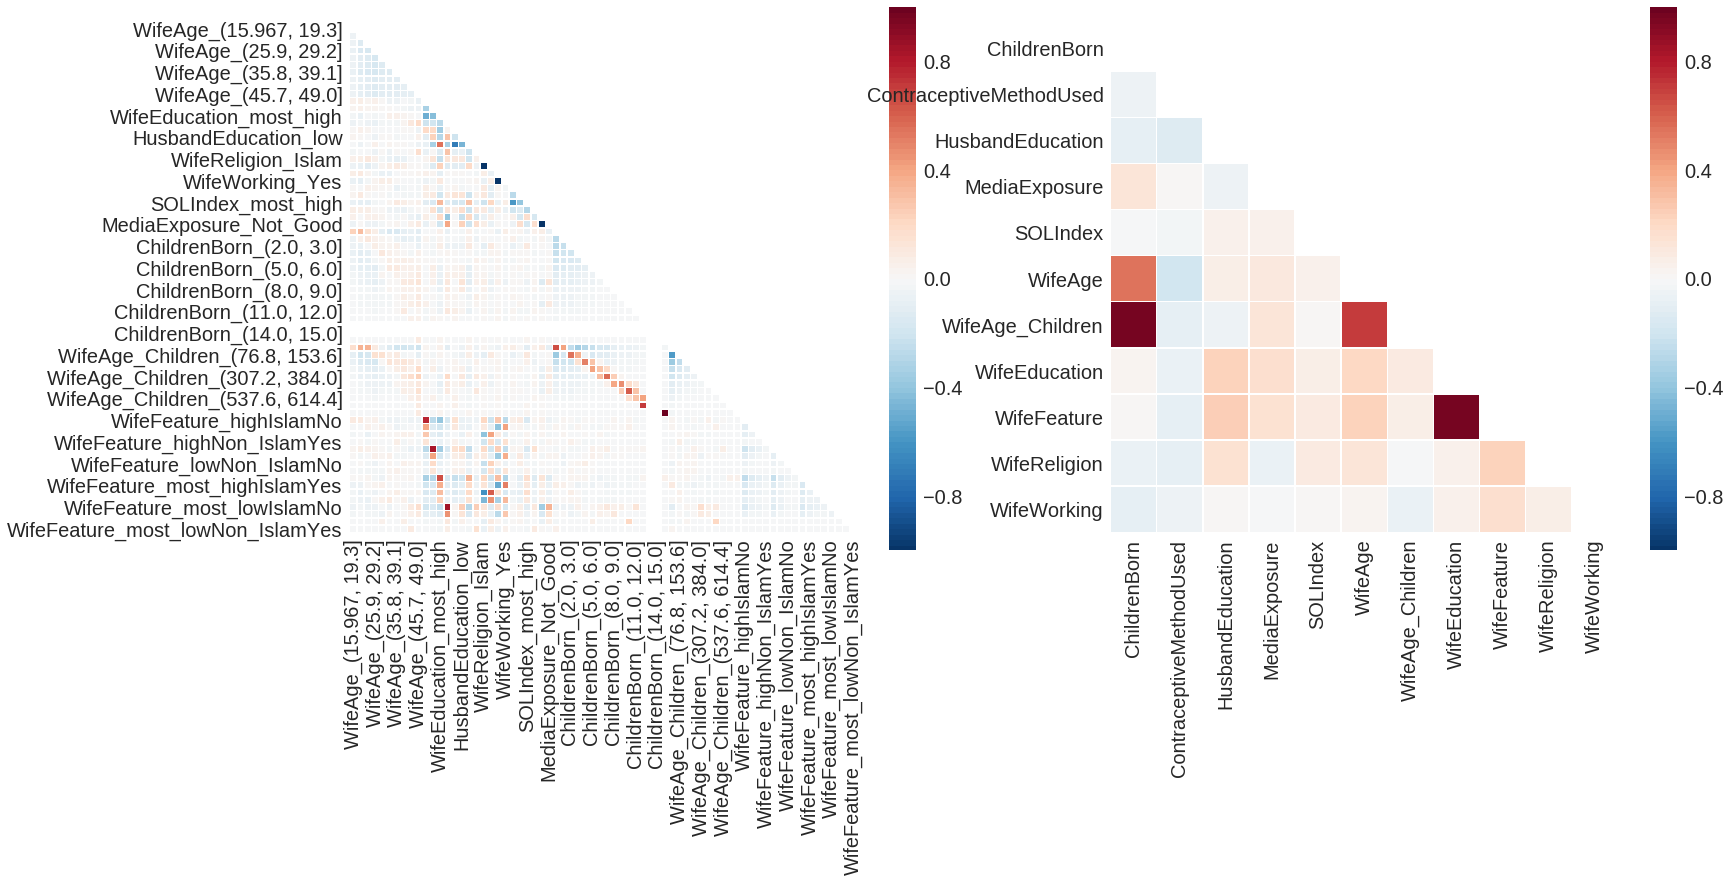

In [96]:
# Create a correlation plot of both datasets.
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
#Generate the mask for the upper triangle
mask = np.zeros_like(dataset_bin_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(dataset_bin_enc.corr(),
           vmin=-1, vmax=1,
           square=True,
           cmap=sns.color_palette("RdBu_r", 100),
           mask=mask,
           linewidths=0.5);

plt.subplot(1, 2, 2)
mask = np.zeros_like(dataset_con_enc.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_con_enc.corr(), 
            vmin=-1, vmax=1, 
            square=True, 
            cmap=sns.color_palette("RdBu_r", 100), 
            mask=mask, 
            linewidths=.5);


### Feature Importance

Random forest consists of a number of decision trees. Every node in the decision trees is a condition on a single feature, designed to split the dataset into two so that similar response values end up in the same set. The measure based on which the (locally) optimal condition is chosen is called impurity. When training a tree, it can be computed how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. This is the feature importance measure exposed in sklearn’s Random Forest implementations.

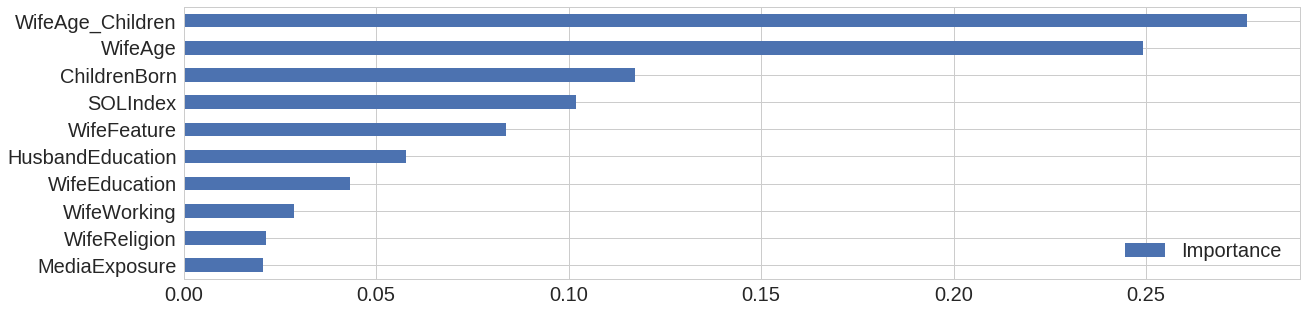

In [102]:
# Using Random Forest to gain an insight on Feature Importance
clf = RandomForestClassifier()
clf.fit(dataset_con_enc.drop('ContraceptiveMethodUsed', axis=1), dataset_con_enc['ContraceptiveMethodUsed'])

plt.style.use('seaborn-whitegrid')
importance = clf.feature_importances_
importance = pd.DataFrame(importance, index=dataset_con_enc.drop('ContraceptiveMethodUsed', axis=1).columns, columns=["Importance"])
importance.sort_values(by='Importance', ascending=True).plot(kind='barh', figsize=(20,len(importance)/2));

### PCA

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. This transformation is defined in such a way that the first principal component has the largest possible variance (that is, accounts for as much of the variability in the data as possible), and each succeeding component in turn has the highest variance possible under the constraint that it is orthogonal to the preceding components.

We can use PCA to reduce the number of features to use in our ML algorithms, and graphing the variance gives us an idea of how many features we really need to represent our dataset fully.

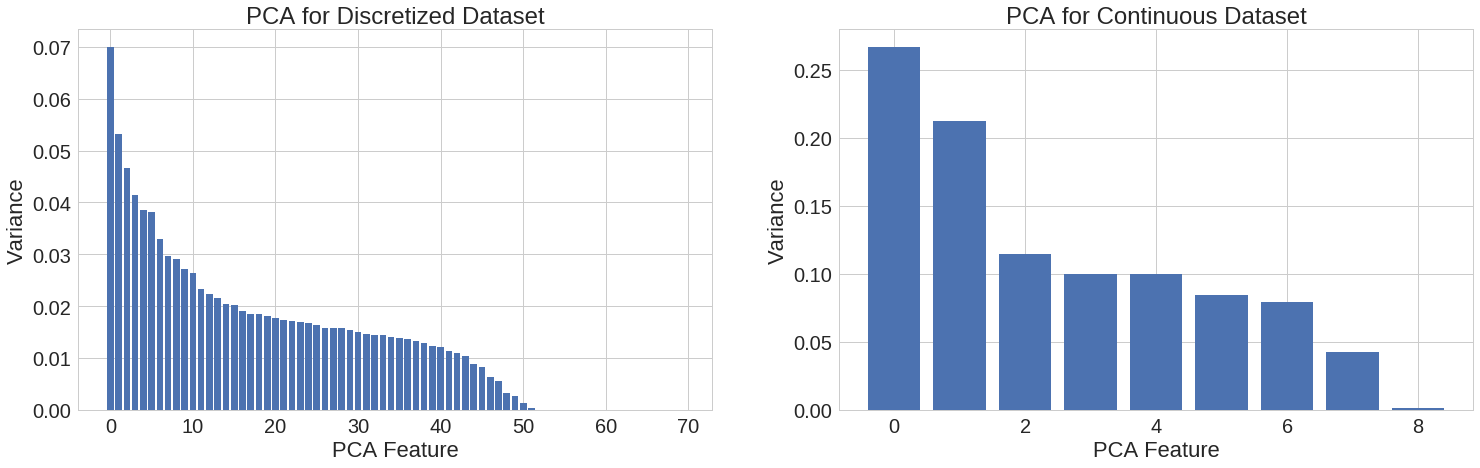

In [103]:
# Calculating PCA for both datasets, graphing the Variance for each feature, per dataset
std_scale = preprocessing.StandardScaler().fit(dataset_bin_enc.drop('ContraceptiveMethodUsed', axis=1))
X = std_scale.transform(dataset_bin_enc.drop('ContraceptiveMethodUsed', axis=1))
pca1 = PCA(n_components=len(dataset_bin_enc.columns)-1)
fit1 = pca1.fit(X)

std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('ContraceptiveMethodUsed', axis=1))
X = std_scale.transform(dataset_con_enc.drop('ContraceptiveMethodUsed', axis=1))
pca2 = PCA(n_components=len(dataset_con_enc.columns)-2)
fit2 = pca2.fit(X)

#Graphing the variances per feature
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(25,7))

plt.subplot(1,2,1)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Discretized Dataset')
plt.bar(range(0, fit1.explained_variance_ratio_.size), fit1.explained_variance_ratio_);

plt.subplot(1,2,2)
plt.xlabel('PCA Feature')
plt.ylabel('Variance')
plt.title('PCA for Continuous Dataset')
plt.bar(range(0, fit2.explained_variance_ratio_.size), fit2.explained_variance_ratio_);

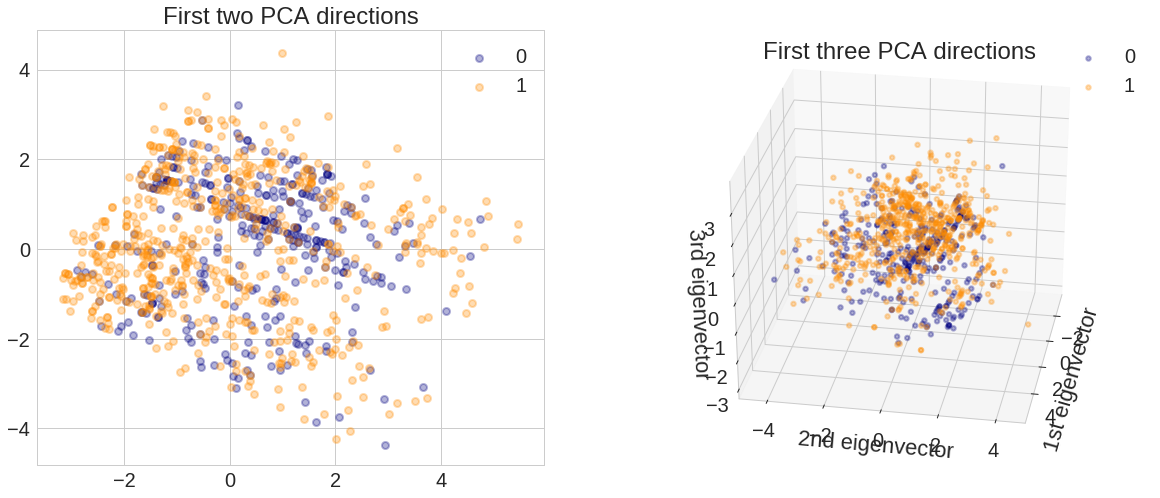

In [106]:
# PCA's components graphed in 2D and 3D
# Apply Scaling
std_scale = preprocessing.StandardScaler().fit(dataset_con_enc.drop('ContraceptiveMethodUsed', axis=1))
X = std_scale.transform(dataset_con_enc.drop('ContraceptiveMethodUsed', axis=1))
y = dataset_con_enc['ContraceptiveMethodUsed']

# Formatting
target_names = [0,1]
colors = ['navy','darkorange']
lw = 2
alpha = 0.3
# 2 Components PCA
plt.style.use('seaborn-whitegrid')
plt.figure(2, figsize=(20, 8))

plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_r[y == i, 0], X_r[y == i, 1], 
                color=color, 
                alpha=alpha, 
                lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('First two PCA directions');

# 3 Components PCA
ax = plt.subplot(1, 2, 2, projection='3d')

pca = PCA(n_components=3)
X_reduced = pca.fit(X).transform(X)
for color, i, target_name in zip(colors, [0, 1], target_names):
    ax.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], X_reduced[y == i, 2], 
               color=color,
               alpha=alpha,
               lw=lw, 
               label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")

# rotate the axes
ax.view_init(30, 10)

## Recursive feature Elimination

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.

Feature Ranking for Non-Discretized: [1 1 1 1 1 1 1 1 1 1]
Optimal number of features: 10


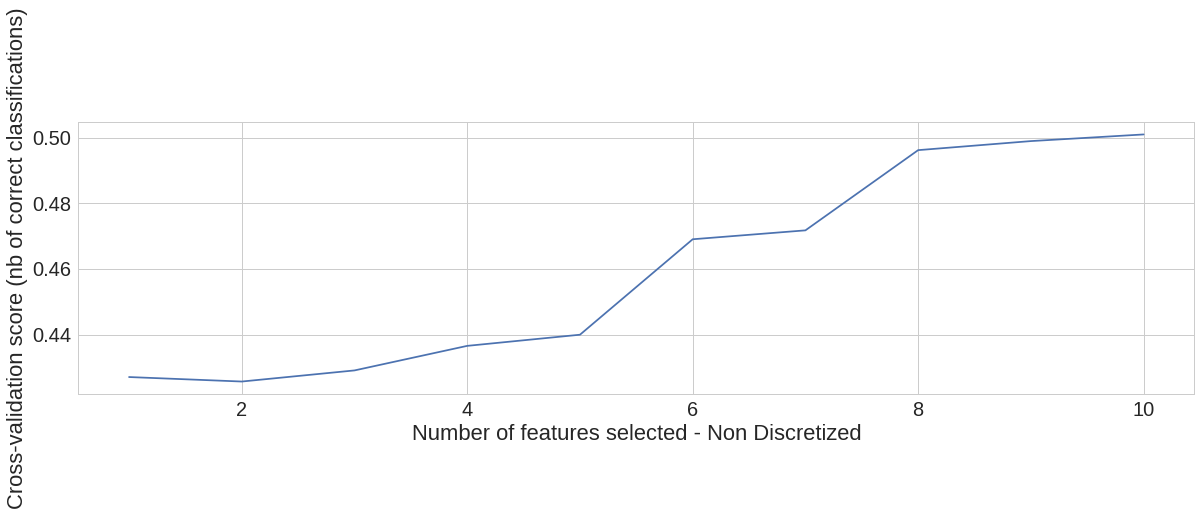

In [109]:
# Calculating RFE for non-discretized dataset, and graphhing the importance for each feature, per dataset
selector1 = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1)
selector1 = selector1.fit(dataset_con_enc.drop('ContraceptiveMethodUsed', axis=1).values, dataset_con_enc['ContraceptiveMethodUsed'].values)
print("Feature Ranking for Non-Discretized: %s" % selector1.ranking_)
print("Optimal number of features: %d" % selector1.n_features_)

# Plot number of features vs cross-validation scores
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5))
plt.xlabel("Number of features selected - Non Discretized")
plt.ylabel("Cross-validation score (nb of correct classifications)")
plt.plot(range(1, len(selector1.grid_scores_)+1), selector1.grid_scores_);

# Feature space could be subsetted like so:
dataset_con_enc = dataset_con_enc[dataset_con_enc.columns[np.insert(selector1.support_,0, True)]]

## Selecting Dataset

We now have two datasets to choose from to apply our ML algorithms. The one-hot-encoded, and the label-encoded. For now, we have decided not to use feature reduction or selection algorithms.

In [110]:
# OPTIONS:
# - dataset_bin_enc
# - dataset_con_enc

# Change te dataset to test how would te algorithm perform under differently encoded datasets.

selected_dataset = dataset_con_enc
selected_dataset.head()

,ChildrenBorn,ContraceptiveMethodUsed,HusbandEducation,MediaExposure,SOLIndex,WifeAge,WifeAge_Children,WifeEducation,WifeFeature,WifeReligion,WifeWorking
0,3,1,0,0,0,8,50,1,4,0,0
1,10,1,0,0,2,29,190,3,12,0,0
2,7,1,0,0,2,27,155,1,4,0,0
3,9,1,1,0,0,26,176,0,0,0,0
4,8,1,0,0,1,20,152,0,0,0,0


## Splitting Data into Training and Testing Datasets

In [113]:
# Splitting dataset into train adn test data
#train = selected_dataset.loc[0:1031,:]
#test = selected_dataset.loc[1031:,:]

In [166]:
# Splitting dataset into train adn test data
train = selected_dataset.sample(frac=0.7)
test = selected_dataset.loc[~selected_dataset.index.isin(train.index)]

### Rename datasets before Machine Learning algos

In [167]:
X_train_w_label = train
X_train = train.drop(['ContraceptiveMethodUsed'], axis=1)
y_train = train['ContraceptiveMethodUsed'].astype('int64')
X_test = test.drop(['ContraceptiveMethodUsed'], axis=1)
y_test = test['ContraceptiveMethodUsed'].astype('int64')

# Machine Learning Algorthims

### Data review

Let's see our data

In [168]:
X_train.shape

(1031, 10)

In [169]:
X_train.head()

,ChildrenBorn,HusbandEducation,MediaExposure,SOLIndex,WifeAge,WifeAge_Children,WifeEducation,WifeFeature,WifeReligion,WifeWorking
162,0,0,0,0,28,0,3,12,0,0
256,2,2,0,2,22,53,0,2,1,0
462,3,2,0,2,20,72,2,8,0,0
90,0,0,0,3,9,0,1,4,0,0
75,1,2,0,0,5,6,0,0,0,0


In [170]:
y_train.head()

162    1
256    1
462    0
90     1
75     1
Name: ContraceptiveMethodUsed, dtype: int64

In [171]:
# Setting a random seed will guarantee we get the same results 
# every time we run our training and testing.
random.seed(123)

### Algorithms

From here, we will be running the following algorithms.

- KNN
- Logistic Regression
- Random Forest
- Naive Bayes
- Stochastic Gradient Decent
- Linear SVC
- Decision Tree
- Gradient Boosted Trees

Because there's a great deal of repetitiveness on the code for each, we'll create a custom function to analyse this.

For some algorithms, we have also chosen to run a Random Hyperparameter search, to select the best hyperparameters for a given algorithm.

In [172]:
# Function that runs the requested algorithm and returns the accuracy metrics

def fit_ml_algo(algo, X_train, y_train, X_test, cv):
    # One pass
    model = algo.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    if (isinstance(algo, (LogisticRegression,
                         KNeighborsClassifier,
                         GaussianNB,
                         DecisionTreeClassifier,
                         RandomForestClassifier,
                         GradientBoostingClassifier))):
        probs = model.predict_proba(X_test)[:,1]
    else:
        probs = "Not Available"
    acc = round(model.score(X_test, y_test)*100, 2)
    
    # CV
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs=-1)
    acc_cv = round(metrics.accuracy_score(y_train, train_pred)*100,2)
    return train_pred, test_pred, acc, acc_cv, probs

In [173]:
# Logistic Regression - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {'penalty': ['l2', 'l1'], 
                         'class_weight': [None, 'balanced'],
                         'C': np.logspace(-20, 20, 10000), 
                         'intercept_scaling': np.logspace(-20, 20, 10000)}

# Run Randomized Search
n_iter_search = 10
lrc = LogisticRegression()
random_search = RandomizedSearchCV(lrc, 
                                   n_jobs=-1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 1.01 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.507 (std: 0.037)
Parameters: {'penalty': 'l2', 'intercept_scaling': 12.305776154924187, 'class_weight': None, 'C': 52.260290219015417}

Model with rank: 2
Mean validation score: 0.469 (std: 0.024)
Parameters: {'penalty': 'l2', 'intercept_scaling': 9.1284289494290072e-17, 'class_weight': 'balanced', 'C': 1565378.8507987061}

Model with rank: 2
Mean validation score: 0.469 (std: 0.024)
Parameters: {'penalty': 'l1', 'intercept_scaling': 2.1327153428312147e-11, 'class_weight': 'balanced', 'C': 359298617015074.12}

Model with rank: 2
Mean validation score: 0.469 (std: 0.024)
Parameters: {'penalty': 'l2', 'intercept_scaling': 1.9294278494248681e-06, 'class_weight': 'balanced', 'C': 97207275246589648.0}

Model with rank: 5
Mean validation score: 0.430 (std: 0.001)
Parameters: {'penalty': 'l2', 'intercept_scaling': 73010670801373.5, 'class_weight': None, 'C': 3.663164195325962

In [174]:
# Logistic Regression
start_time = time.time()
train_pred_log, test_pred_log, acc_log, acc_cv_log, probs_log = fit_ml_algo(LogisticRegression(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 47.96
Accuracy CV 10-Fold: 49.37
Running Time: 0:00:00.878386


In [175]:
#from sklearn.metrics import classification_report
print(metrics.classification_report(y_train, train_pred_log))

             precision    recall  f1-score   support

          0       0.40      0.16      0.23       217
          1       0.53      0.59      0.56       443
          2       0.47      0.57      0.52       371

avg / total       0.48      0.49      0.47      1031



In [176]:
print(metrics.classification_report(y_test, test_pred_log))

             precision    recall  f1-score   support

          0       0.54      0.18      0.27       116
          1       0.52      0.61      0.56       186
          2       0.42      0.56      0.48       140

avg / total       0.49      0.48      0.46       442



In [177]:
# k-Nearest Neighbors
start_time = time.time()
train_pred_knn, test_pred_knn, acc_knn, acc_cv_knn, probs_knn = fit_ml_algo(KNeighborsClassifier(n_neighbors = 3,
                                                                                                 n_jobs = -1), 
                                                                                                 X_train, 
                                                                                                 y_train, 
                                                                                                 X_test, 
                                                                                                 10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 48.64
Accuracy CV 10-Fold: 47.24
Running Time: 0:00:01.343435


In [178]:
print(metrics.classification_report(y_train, train_pred_knn))

             precision    recall  f1-score   support

          0       0.32      0.45      0.37       217
          1       0.57      0.52      0.55       443
          2       0.49      0.43      0.45       371

avg / total       0.49      0.47      0.48      1031



In [179]:
print(metrics.classification_report(y_test, test_pred_knn))

             precision    recall  f1-score   support

          0       0.41      0.47      0.44       116
          1       0.64      0.58      0.61       186
          2       0.37      0.38      0.38       140

avg / total       0.50      0.49      0.49       442



In [180]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, test_pred_gaussian, acc_gaussian, acc_cv_gaussian, probs_gau = fit_ml_algo(GaussianNB(), 
                                                                                     X_train, 
                                                                                     y_train, 
                                                                                     X_test, 
                                                                                     10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 51.81
Accuracy CV 10-Fold: 48.4
Running Time: 0:00:00.631485


In [181]:
print(metrics.classification_report(y_train, train_pred_gaussian))

             precision    recall  f1-score   support

          0       0.35      0.48      0.41       217
          1       0.65      0.39      0.49       443
          2       0.47      0.60      0.53       371

avg / total       0.52      0.48      0.49      1031



In [182]:
print(metrics.classification_report(y_test, test_pred_gaussian))

             precision    recall  f1-score   support

          0       0.44      0.47      0.45       116
          1       0.76      0.48      0.59       186
          2       0.43      0.61      0.50       140

avg / total       0.57      0.52      0.53       442



In [183]:
# Linear SVC
start_time = time.time()
train_pred_svc, test_pred_svc, acc_linear_svc, acc_cv_linear_svc, _ = fit_ml_algo(LinearSVC(),
                                                                                           X_train, 
                                                                                           y_train,
                                                                                           X_test, 
                                                                                           10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 45.25
Accuracy CV 10-Fold: 45.59
Running Time: 0:00:01.939719


In [184]:
print(metrics.classification_report(y_train, train_pred_svc))

             precision    recall  f1-score   support

          0       0.27      0.12      0.17       217
          1       0.53      0.58      0.55       443
          2       0.42      0.51      0.46       371

avg / total       0.43      0.46      0.44      1031



In [185]:
print(metrics.classification_report(y_test, test_pred_svc)) 

             precision    recall  f1-score   support

          0       0.46      0.18      0.26       116
          1       0.70      0.35      0.47       186
          2       0.37      0.81      0.51       140

avg / total       0.53      0.45      0.43       442



In [186]:
# Stochastic Gradient Descent
start_time = time.time()
train_pred_sgd, test_pred_sgd, acc_sgd, acc_cv_sgd, _ = fit_ml_algo(SGDClassifier(n_jobs = -1), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
sgd_time = (time.time() - start_time)
print("Accuracy: %s" % acc_sgd)
print("Accuracy CV 10-Fold: %s" % acc_cv_sgd)
print("Running Time: %s" % datetime.timedelta(seconds=sgd_time))

Accuracy: 41.86
Accuracy CV 10-Fold: 39.19
Running Time: 0:00:01.224299


In [187]:
print(metrics.classification_report(y_train, train_pred_sgd))

             precision    recall  f1-score   support

          0       0.24      0.39      0.30       217
          1       0.67      0.26      0.38       443
          2       0.40      0.55      0.46       371

avg / total       0.48      0.39      0.39      1031



In [188]:
print(metrics.classification_report(y_test, test_pred_sgd))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       116
          1       0.42      0.98      0.59       186
          2       0.33      0.01      0.03       140

avg / total       0.28      0.42      0.26       442



In [189]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, test_pred_dt, acc_dt, acc_cv_dt, probs_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 46.83
Accuracy CV 10-Fold: 46.36
Running Time: 0:00:00.511199


In [190]:
print(metrics.classification_report(y_train, train_pred_dt))

             precision    recall  f1-score   support

          0       0.32      0.37      0.34       217
          1       0.56      0.54      0.55       443
          2       0.45      0.42      0.43       371

avg / total       0.47      0.46      0.47      1031



In [191]:
print(metrics.classification_report(y_test, test_pred_dt))

             precision    recall  f1-score   support

          0       0.44      0.38      0.41       116
          1       0.55      0.60      0.58       186
          2       0.37      0.36      0.37       140

avg / total       0.46      0.47      0.47       442



In [192]:
# Random Forest Classifier - Random Search for Hyperparameters

# Utility function to report best scores
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
# Specify parameters and distributions to sample from
param_dist = {"max_depth": [10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# Run Randomized Search
n_iter_search = 10
rfc = RandomForestClassifier(n_estimators=10)
random_search = RandomizedSearchCV(rfc, 
                                   n_jobs = -1, 
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search)

start = time.time()
random_search.fit(X_train, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 1.06 seconds for 10 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.549 (std: 0.030)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 5, 'min_samples_leaf': 7, 'min_samples_split': 16}

Model with rank: 2
Mean validation score: 0.547 (std: 0.034)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 10, 'max_features': 7, 'min_samples_leaf': 8, 'min_samples_split': 4}

Model with rank: 3
Mean validation score: 0.545 (std: 0.042)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 5}

Model with rank: 4
Mean validation score: 0.540 (std: 0.035)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9, 'min_samples_split': 8}

Model with rank: 5
Mean validation score: 0.532 (std: 0.022)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max

In [193]:
# Random Forest Classifier
start_time = time.time()
rfc = RandomForestClassifier(n_estimators=10, 
                             min_samples_leaf=2,
                             min_samples_split=17, 
                             criterion='gini', 
                             max_features=8)
train_pred_rf, test_pred_rf, acc_rf, acc_cv_rf, probs_rf = fit_ml_algo(rfc, 
                                                             X_train, 
                                                             y_train, 
                                                             X_test, 
                                                             10)
rf_time = (time.time() - start_time)
print("Accuracy: %s" % acc_rf)
print("Accuracy CV 10-Fold: %s" % acc_cv_rf)
print("Running Time: %s" % datetime.timedelta(seconds=rf_time))

Accuracy: 52.49
Accuracy CV 10-Fold: 53.73
Running Time: 0:00:00.729587


In [194]:
print(metrics.classification_report(y_train, train_pred_rf))

             precision    recall  f1-score   support

          0       0.42      0.25      0.31       217
          1       0.60      0.65      0.62       443
          2       0.50      0.58      0.54       371

avg / total       0.53      0.54      0.53      1031



In [195]:
print(metrics.classification_report(y_test, test_pred_rf))

             precision    recall  f1-score   support

          0       0.64      0.28      0.39       116
          1       0.61      0.67      0.64       186
          2       0.40      0.54      0.46       140

avg / total       0.55      0.52      0.52       442



In [196]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, test_pred_gbt, acc_gbt, acc_cv_gbt, probs_gbt = fit_ml_algo(GradientBoostingClassifier(), 
                                                                 X_train, 
                                                                 y_train, 
                                                                 X_test, 
                                                                 10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

Accuracy: 51.81
Accuracy CV 10-Fold: 55.09
Running Time: 0:00:02.821758


In [197]:
print(metrics.classification_report(y_train, train_pred_gbt))

             precision    recall  f1-score   support

          0       0.42      0.31      0.36       217
          1       0.64      0.63      0.63       443
          2       0.51      0.60      0.55       371

avg / total       0.55      0.55      0.55      1031



In [198]:
print(metrics.classification_report(y_test, test_pred_gbt))

             precision    recall  f1-score   support

          0       0.56      0.28      0.37       116
          1       0.61      0.67      0.64       186
          2       0.40      0.52      0.45       140

avg / total       0.53      0.52      0.51       442



In [199]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_knn, 
        acc_log, 
        acc_rf, 
        acc_gaussian, 
        acc_sgd, 
        acc_linear_svc, 
        acc_dt,
        acc_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
2,Random Forest,52.49
3,Naive Bayes,51.81
7,Gradient Boosting Trees,51.81
0,KNN,48.64
1,Logistic Regression,47.96
6,Decision Tree,46.83
5,Linear SVC,45.25
4,Stochastic Gradient Decent,41.86


In [200]:
models = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees'],
    'Score': [
        acc_cv_knn, 
        acc_cv_log,     
        acc_cv_rf, 
        acc_cv_gaussian, 
        acc_cv_sgd, 
        acc_cv_linear_svc, 
        acc_cv_dt,
        acc_cv_gbt
    ]})
models.sort_values(by='Score', ascending=False)

,Model,Score
7,Gradient Boosting Trees,55.09
2,Random Forest,53.73
1,Logistic Regression,49.37
3,Naive Bayes,48.40
0,KNN,47.24
6,Decision Tree,46.36
5,Linear SVC,45.59
4,Stochastic Gradient Decent,39.19


## Tensorflow - Logistic Regression

### Converting Data into Tensors
When building a TF.Learn model, the input data is specified by means of an Input Builder function. This builder function will not be called until it is later passed to TF.Learn methods such as fit and evaluate. The purpose of this function is to construct the input data, which is represented in the form of tf.Tensors or tf.SparseTensors. In more detail, the Input Builder function returns the following as a pair:

- feature_cols: A dict from feature column names to Tensors or SparseTensors.
- label: A Tensor containing the label column.

In [201]:
df1 = pd.DataFrame(dataset_con.dtypes, columns=['Continuous Type'])
df2 = pd.DataFrame(dataset_bin.dtypes, columns=['Discretised Type'])
pd.concat([df1, df2], axis=1).transpose()

,ContraceptiveMethodUsed,WifeAge,WifeEducation,HusbandEducation,WifeReligion,WifeWorking,SOLIndex,MediaExposure,ChildrenBorn,WifeAge_Children,WifeFeature
Continuous Type,object,int64,object,object,object,object,object,object,int64,int64,object
Discretised Type,object,category,object,object,object,object,object,object,category,category,object


In [221]:
# Selecting the Continuous Dataset
LABEL_COLUMN = "label"
dataset_con[LABEL_COLUMN] = raw_data["ContraceptiveMethodUsed"].astype(int)

CONTINUOUS_COLUMNS = dataset_con.select_dtypes(include=[np.number]).columns.tolist()
CATEGORICAL_COLUMNS = [
    'WifeEducation',
    'HusbandEducation',
    'WifeReligion',
    'WifeWorking',
    'WifeFeature',
    'SOLIndex',
    'MediaExposure'
]


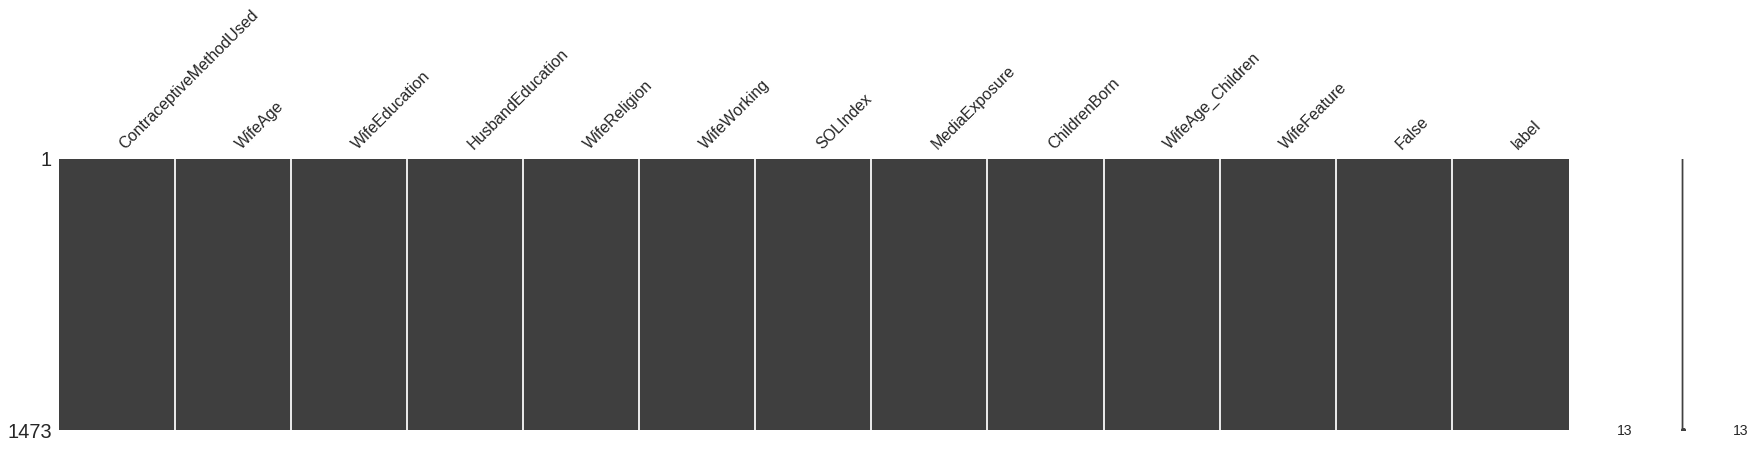

In [222]:
# Missing Values
missingno.matrix(dataset_con, figsize = (30,5))

In [223]:
# Splitting dataset into train adn test data
train = dataset_con.sample(frac=0.7)
test = dataset_con.loc[~dataset_con.index.isin(train.index)]

In [224]:
# Coverting Dataframes into Tensors
def input_fn(df):
    # Creates a dictionary mapping from each continuous feature column name (k) to
    # the values of that column stored in a constant Tensor.
    continuous_cols = {k: tf.constant(df[k].values) for k in CONTINUOUS_COLUMNS}
    # Creates a dictionary mapping from each categorical feature column name (k)
    # to the values of that column stored in a tf.SparseTensor.
    categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(df[k].size)],
      values=df[k].values,
      dense_shape=[df[k].size, 1]) for k in CATEGORICAL_COLUMNS
                     }
    # Merges the two dictionaries into one.
    #feature_cols = dict(continuous_cols.items() + categorical_cols.items())
    feature_cols = continuous_cols.copy()
    feature_cols.update(categorical_cols)
    # Converts the label column into a constant Tensor.
    label = tf.constant(df[LABEL_COLUMN].values)
    # Returns the feature columns and the label.
    return feature_cols, label

def train_input_fn():
    return input_fn(train)

def eval_input_fn():
    return input_fn(test)

### Base Categorical Feature Columns
To define a feature column for a categorical feature, we can create a SparseColumn using the TF.Learn API. If you know the set of all possible feature values of a column and there are only a few of them, you can use sparse_column_with_keys. Each key in the list will get assigned an auto-incremental ID starting from 0. If we don't know the set of possible values in advance, we can use sparse_column_with_hash_bucket instead:

In [225]:
# Listing categorical classes for reference
train.select_dtypes(include=[np.object]).columns.tolist()

['ContraceptiveMethodUsed',
 'WifeEducation',
 'HusbandEducation',
 'WifeReligion',
 'WifeWorking',
 'SOLIndex',
 'MediaExposure',
 'WifeFeature']

In [226]:
ContraceptiveMethodUsed = tf.contrib.layers.sparse_column_with_hash_bucket("ContraceptiveMethodUsed", hash_bucket_size=100)
WifeEducation = tf.contrib.layers.sparse_column_with_hash_bucket("WifeEducation", hash_bucket_size=1000)
HusbandEducation = tf.contrib.layers.sparse_column_with_hash_bucket("HusbandEducation", hash_bucket_size=100)
WifeReligion = tf.contrib.layers.sparse_column_with_hash_bucket("WifeReligion", hash_bucket_size=100)
WifeWorking = tf.contrib.layers.sparse_column_with_hash_bucket("WifeWorking", hash_bucket_size=100)
SOLIndex = tf.contrib.layers.sparse_column_with_hash_bucket("SOLIndex", hash_bucket_size=1000)
MediaExposure = tf.contrib.layers.sparse_column_with_hash_bucket("MediaExposure", hash_bucket_size=100)
WifeFeature = tf.contrib.layers.sparse_column_with_hash_bucket("WifeFeature", hash_bucket_size=100)

### Base Continuous Feature Columns
Similarly, we can define a RealValuedColumn for each continuous feature column that we want to use in the model:

In [227]:
train.select_dtypes(include=[np.number]).columns.tolist()

['WifeAge', 'ChildrenBorn', 'WifeAge_Children', False, 'label']

In [228]:
WifeAge = tf.contrib.layers.real_valued_column("WifeAge")
ChildrenBorn = tf.contrib.layers.real_valued_column("ChildrenBorn")
WifeAge_Children = tf.contrib.layers.real_valued_column("WifeAge_Children")


### Defining The Logistic Regression Model

After processing the input data and defining all the feature columns, we're now ready to put them all together and build a Logistic Regression model.

In [229]:
model_dir = tempfile.mkdtemp()
m = tf.contrib.learn.LinearClassifier(feature_columns=[
    WifeAge,
    WifeEducation,
    HusbandEducation,
    WifeReligion,
    WifeWorking,
    SOLIndex,
    MediaExposure,
    ChildrenBorn,
    WifeAge_Children,
    WifeFeature
    ],
    model_dir=model_dir)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2319c42d30>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tmp_m8byvt_'}


### Training and Evaluating Our Model

After adding all the features to the model, now let's look at how to actually train the model. Training a model is just a one-liner using the TF.Learn API:

In [230]:
m.fit(input_fn=train_input_fn, steps=200)

Instructions for updating:
Please switch to tf.train.get_global_step
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp_m8byvt_/model.ckpt.
INFO:tensorflow:loss = 0.693146, step = 1
INFO:tensorflow:global_step/sec: 372.656
INFO:tensorflow:loss = -493.797, step = 101 (0.271 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmp_m8byvt_/model.ckpt.
INFO:tensorflow:Loss for final step: -721.45.


LinearClassifier(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._BinaryLogisticHead object at 0x7f2319c42ba8>, 'feature_columns': [_RealValuedColumn(column_name='WifeAge', dimension=1, default_value=None, dtype=tf.float32, normalizer=None), _SparseColumnHashed(column_name='WifeEducation', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumnHashed(column_name='HusbandEducation', is_integerized=False, bucket_size=100, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumnHashed(column_name='WifeReligion', is_integerized=False, bucket_size=100, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumnHashed(column_name='WifeWorking', is_integerized=False, bucket_size=100, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumnHashed(column_name='SOLIndex', is_integerized=False, bucket_size=1000, lookup_config=None, combiner='sum', dtype=tf.string), _SparseColumnHashed(column_n

After the model is trained, we can evaluate how good our model is at predicting the labels of the holdout data:

In [231]:
results = m.evaluate(input_fn=eval_input_fn, steps=1)
for key in sorted(results):
    print("%s: %s" % (key, results[key]))

INFO:tensorflow:Starting evaluation at 2017-12-26-13:40:18
INFO:tensorflow:Restoring parameters from /tmp/tmp_m8byvt_/model.ckpt-200
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-26-13:40:19
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.38914, accuracy/baseline_label_mean = 1.99774, accuracy/threshold_0.500000_mean = 0.38914, auc = 0.0, auc_precision_recall = 1.0, global_step = 200, labels/actual_label_mean = 1.99774, labels/prediction_mean = 1.0, loss = -845.683, precision/positive_threshold_0.500000_mean = 1.0, recall/positive_threshold_0.500000_mean = 1.0
accuracy: 0.38914
accuracy/baseline_label_mean: 1.99774
accuracy/threshold_0.500000_mean: 0.38914
auc: 0.0
auc_precision_recall: 1.0
global_step: 200
labels/actual_label_mean: 1.99774
labels/prediction_mean: 1.0
loss: -845.683
precision/positive_threshold_0.500000_mean: 1.0
recall/positive_threshold_0.500000_mean: 1.0
